In [1]:
import re
import numpy as np
import sympy as sp
from collections import OrderedDict as odict
from collections import namedtuple as ntuple
from functools import reduce
from itertools import product
%load_ext autoreload
%autoreload 2
import tensorops as to
from notation import *
# from functools import lru_cache
import os 
import pickle
import matplotlib.pyplot as plt
from fractions import Fraction
import pandas as pd
from collections import Counter

In [2]:
cfps_folder = './data'

# named tuples
State = ntuple('State',['seniority','sup_irrep'])
Term = ntuple('Term',['S','L','W'])
CFP = ntuple('CFP',['daughter', 'parent_n_minus_b','parent_b'])
Config = ntuple('Config',['l','n'])

## Concatenate

In [35]:
all_fnames = os.listdir(cfps_folder)
for body_num in [1,2,3,4]:
    for l in [1,2,3]:
        l_string = l_notation_switch(l)
        all_fname = os.path.join(cfps_folder, 'B%d%s_ALL.txt' % (body_num, l_string.upper()))
        if not os.path.exists(all_fname):
            radix = 'B%d%s' % (body_num, l_string.upper())
            fnames = [f for f in all_fnames if f[:3] == radix]
            fnames = list(sorted(fnames))
            fnames = [os.path.join(cfps_folder, f) for f in fnames]
            if len(fnames) == 0:
                continue
            print(radix)
            loaded = '\n'.join([open(f,'r').read() for f in fnames])
            open(all_fname,'w').write(loaded)

## 1 body CFPS

In [91]:
all_cfps = odict()
all_cfps_prime = odict()
clear_text_sprime = ['l n daughter parent_nmb parent_b cfp_sqrt_prime_notation']
clear_text_float = ['l n daughter parent_nmb parent_b cfp_float']
all_nums = []
for l in [1,2,3]:
    fname = os.path.join(cfps_folder,'B1%s_ALL.txt' % l_notation_switch(l).upper())
    lines = open(fname,'r').read().split('\n')
    cfps = odict()
    cfps_prime = odict()
    for line in lines:
        oline = line
        if line == '':
            continue
        if line[0] == '[':
            sector = line.split(']')[0][-2:]
            sector = Config(l_notation_switch(sector[0]),int(sector[1]))
            cfps[sector] = odict()
            cfps_prime[sector] = odict()
            continue
        if '[DAUGHTER TERM]' in line:
            dau = line.split('[')[0]
            assert len(dau) <= 4
            if not dau[-1].isdigit():
                W_dau = 1
            else:
                W_dau = int(dau[2:])
            L_dau, SMulti_dau =  l_notation_switch(dau[1]), int(dau[0])
            S_dau = sp.S(SMulti_dau-1)/2
            term_dau = Term(S_dau, L_dau, W_dau)
        else:
            line = line.replace('-',' -')
            rline = re.sub(' +', ' ', line.strip())
            rline = rline.split(' ')
            parent_nm2 = rline[0]
            assert len(parent_nm2) <= 4
            if not parent_nm2[-1].isdigit():
                W_par_nm2 = 1
            else:
                W_par_nm2 = int(parent_nm2[2:])
            L_par_nm2, SMulti_par_nm2 = l_notation_switch(parent_nm2[1]), int(parent_nm2[0])
            S_par_nm2 = sp.S(SMulti_par_nm2-1)/2
            term_par_nm2 = Term(S_par_nm2, L_par_nm2, W_par_nm2)
            parent_2 = rline[1]
            assert len(parent_2) <= 4
            if not parent_2[-1].isdigit():
                W_par_2 = 1
            else:
                W_par_2 = int(parent_2[2:])
            L_par_2, SMulti_par_2 = l_notation_switch(parent_2[1]), int(parent_2[0])
            S_par_2 = sp.S(SMulti_par_2-1)/2
            term_par_2 = Term(S_par_2, L_par_2, W_par_2)
            cfp = ' '.join(rline[2:])
            cfp_num = prime_parser(cfp)
            cfps[sector][CFP(term_dau,term_par_nm2,term_par_2)] = cfp_num
            cfp_clear = clarify_rep(cfp)
            cfps_prime[sector][CFP(term_dau,term_par_nm2, term_par_2)] = cfp_clear
            clear_row = [str(l), str(sector.n), '%d%s%s' % (2*term_dau.S+1, l_notation_switch(term_dau.L).upper(), term_dau.W),
                        '%d%s%s' % (2*term_par_nm2.S+1, l_notation_switch(term_par_nm2.L).upper(), term_par_nm2.W), 
                        '%d%s%s' % (2*term_par_2.S+1, l_notation_switch(term_par_2.L).upper(), term_par_2.W),
                        cfp_clear]
            clear_row = ' '.join(clear_row)
            clear_text_sprime.append(clear_row)
            clear_row = [str(l), str(sector.n), '%d%s%s' % (2*term_dau.S+1, l_notation_switch(term_dau.L).upper(), term_dau.W),
                        '%d%s%s' % (2*term_par_nm2.S+1, l_notation_switch(term_par_nm2.L).upper(), term_par_nm2.W), 
                        '%d%s%s' % (2*term_par_2.S+1, l_notation_switch(term_par_2.L).upper(), term_par_2.W),
                         '%.24E' % (cfp_num)]
            clear_row = ' '.join(clear_row)
            clear_text_float.append(clear_row)
            all_nums.append(float(cfp_num))
    all_cfps[l] = cfps
    all_cfps_prime[l] = cfps_prime
# open('./data/cfp_sprime.txt','w').write('\n'.join(clear_text_sprime))
# open('./data/cfp_float.txt','w').write('\n'.join(clear_text_float))
# pickle.dump(all_cfps,open('./data/cfps.pkl','wb'))

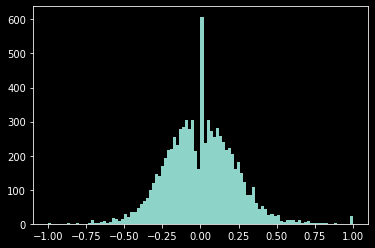

In [47]:
plt.figure()
plt.hist(all_nums, bins=100)
plt.show()

## 2 body CFPS

In [85]:
cfps_folder = '/Users/juan/cfps'

all_cfps = odict()
all_cfps_prime = odict()
clear_text_sprime = ['l n daughter parent_nm2 parent_2 cfp_sqrt_prime_notation']
clear_text_float = ['l n daughter parent_nm2 parent_2 cfp_float']
all_nums = []
for l in [1,2]:
    if l in [1,2]:
        fname = os.path.join(cfps_folder,'B2%s_ALL.txt' % l_notation_switch(l).upper())
        lines = open(fname,'r').read().split('\n')
    else:
        lines = []
        for i in [3,4,5,6,7,8]:
            fname = os.path.join(cfps_folder,'B2%s%d_00.txt' % (l_notation_switch(l).upper(),i))
            lines.extend(open(fname,'r').read().split('\n'))
    cfps = odict()
    cfps_prime = odict()
    for line in lines:
        oline = line
        if line == '':
            continue
        if line[0] == '[':
            sector = line.split(']')[0][-2:]
            sector = Config(l_notation_switch(sector[0]),int(sector[1]))
            cfps[sector] = odict()
            cfps_prime[sector] = odict()
            continue
        if '[DAUGHTER TERM]' in line:
            dau = line.split('[')[0]
            assert len(dau) <= 4
            if not dau[-1].isdigit():
                W_dau = 1
            else:
                W_dau = int(dau[2:])
            L_dau, SMulti_dau =  l_notation_switch(dau[1]), int(dau[0])
            S_dau = sp.S(SMulti_dau-1)/2
            term_dau = Term(S_dau, L_dau, W_dau)
        else:
            line = line.replace('-',' -')
            rline = re.sub(' +', ' ', line.strip())
            rline = rline.split(' ')
            parent_nm2 = rline[0]
            assert len(parent_nm2) <= 4
            if not parent_nm2[-1].isdigit():
                W_par_nm2 = 1
            else:
                W_par_nm2 = int(parent_nm2[2:])
            L_par_nm2, SMulti_par_nm2 = l_notation_switch(parent_nm2[1]), int(parent_nm2[0])
            S_par_nm2 = sp.S(SMulti_par_nm2-1)/2
            term_par_nm2 = Term(S_par_nm2, L_par_nm2, W_par_nm2)
            parent_2 = rline[1]
            assert len(parent_2) <= 4
            if not parent_2[-1].isdigit():
                W_par_2 = 1
            else:
                W_par_2 = int(parent_2[2:])
            L_par_2, SMulti_par_2 = l_notation_switch(parent_2[1]), int(parent_2[0])
            S_par_2 = sp.S(SMulti_par_2-1)/2
            term_par_2 = Term(S_par_2, L_par_2, W_par_2)
            cfp = ' '.join(rline[2:])
            cfp_num = prime_parser(cfp)
            cfps[sector][CFP(term_dau,term_par_nm2,term_par_2)] = cfp_num
            cfp_clear = clarify_rep(cfp)
            cfps_prime[sector][CFP(term_dau,term_par)] = cfp_clear
            clear_row = [str(l), str(sector.n), '%d%s%s' % (2*term_dau.S+1, l_notation_switch(term_dau.L).upper(), term_dau.W),
                        '%d%s%s' % (2*term_par_nm2.S+1, l_notation_switch(term_par_nm2.L).upper(), term_par_nm2.W), 
                        '%d%s%s' % (2*term_par_2.S+1, l_notation_switch(term_par_2.L).upper(), term_par_2.W),
                        cfp_clear]
            clear_row = ' '.join(clear_row)
            clear_text_sprime.append(clear_row)
            clear_row = [str(l), str(sector.n), '%d%s%s' % (2*term_dau.S+1, l_notation_switch(term_dau.L).upper(), term_dau.W),
                        '%d%s%s' % (2*term_par_nm2.S+1, l_notation_switch(term_par_nm2.L).upper(), term_par_nm2.W), 
                        '%d%s%s' % (2*term_par_2.S+1, l_notation_switch(term_par_2.L).upper(), term_par_2.W),
                         '%.24E' % (cfp_num)]
            clear_row = ' '.join(clear_row)
            clear_text_float.append(clear_row)
            all_nums.append(float(cfp_num))
    all_cfps[l] = cfps
    all_cfps_prime[l] = cfps_prime
# open('./data/cfp_sprime.txt','w').write('\n'.join(clear_text_sprime))
# open('./data/cfp_float.txt','w').write('\n'.join(clear_text_float))
# pickle.dump(all_cfps,open('./data/cfps.pkl','wb'))

## all body CFPS

In [30]:
# cfps_folder = './data'
# all_all_cfps = odict()
# all_cfps = odict()
# all_cfps_prime = odict()
# big_frame = []
# big_dict = {}
# cfp_template = ntuple('cfp','bod l n_daughter S_daughter L_daughter W_daughter nparent_minus_bod S_parent_n_minus_bod L_parent_n_minus_bod W_parent_n_minus_bod nparent_bod S_parent_bod L_parent_bod W_parent_bod'.split(' '))
# for body_num in [1]:
#     clear_text_sprime = ['l n daughter parent_n-%d parent_%d cfp_sqrt_prime_notation' % (body_num,body_num)]
#     clear_text_float = ['l n daughter parent_n-%d parent_%d cfp_float' % (body_num,body_num)]
#     all_nums = []
#     body_cfps_dict = {}
#     body_cfps_rows = []
#     for l in [1,2,3]:
#         print((body_num, l_notation_switch(l).upper()))
#         fname = os.path.join(cfps_folder,'B%d%s_ALL.txt' % (body_num, l_notation_switch(l).upper()))
#         if not os.path.exists(fname):
#             continue
#         lines = open(fname,'r').read().split('\n')
#         cfps = odict()
#         cfps_prime = odict()
#         for line in lines:
#             oline = line
#             if line == '' or line[0] == '/':
#                 continue
#             if line[0] == '[':
#                 sector = line.split(']')[0][-2:]
#                 sector = Config(l_notation_switch(sector[0]),int(sector[1]))
#                 cfps[sector] = odict()
#                 cfps_prime[sector] = odict()
#                 continue
#             if '[DAUGHTER TERM]' in line:
#                 dau = line.split('[')[0]
#                 assert len(dau) <= 4
#                 if not dau[-1].isdigit():
#                     W_dau = 1
#                 else:
#                     W_dau = int(dau[2:])
#                 L_dau, SMulti_dau =  l_notation_switch(dau[1]), int(dau[0])
#                 S_dau = sp.S(SMulti_dau-1)/2
#                 term_dau = Term(S_dau, L_dau, W_dau)
#                 n = body_num
#                 nprime = n - body_num
#                 nprimeprime = body_num
#             else:
#                 line = line.replace('-',' -')
#                 rline = re.sub(' +', ' ', line.strip())
#                 rline = rline.split(' ')
#                 parent_n_minus_bod = rline[0]
#                 assert len(parent_n_minus_bod) <= 4
#                 if not parent_n_minus_bod[-1].isdigit():
#                     W_par_n_minus_bod = 1
#                 else:
#                     W_par_n_minus_bod = int(parent_n_minus_bod[2:])
#                 L_par_n_minus_bod, SMulti_par_n_minus_bod = l_notation_switch(parent_n_minus_bod[1]), int(parent_n_minus_bod[0])
#                 S_par_n_minus_bod = sp.S(SMulti_par_n_minus_bod-1)/2
#                 term_parent_1 = Term(S_par_n_minus_bod, L_par_n_minus_bod, W_par_n_minus_bod)
#                 parent_bod = rline[1]
#                 assert len(parent_bod) <= 4
#                 if not parent_bod[-1].isdigit():
#                     W_par_bod = 1
#                 else:
#                     W_par_bod = int(parent_bod[2:])
#                 L_par_bod, SMulti_par_bod = l_notation_switch(parent_bod[1]), int(parent_bod[0])
#                 S_par_bod = sp.S(SMulti_par_bod-1)/2
#                 term_parent_2 = Term(S_par_bod, L_par_bod, W_par_bod)
#                 cfp = ' '.join(rline[2:])
#                 cfp_num = prime_parser(cfp)
#                 cfps[sector][CFP(term_dau,term_parent_1,term_parent_2)] = cfp_num
#                 row = (body_num, sector.l, sector.n, *term_dau, nprime, *term_parent_1, nprimeprime, *term_parent_2, cfp_num)
#                 big_frame.append(row)
#                 big_dict[cfp_template(body_num, sector.l, sector.n, *term_dau, nprime, *term_parent_1, nprimeprime, *term_parent_2)] = cfp_num
#                 key = (body_num, sector.l, 
#                        sector.n, *term_dau, 
#                        nprime, *term_parent_1, 
#                        nprimeprime, *term_parent_2)
#                 body_cfps_dict[key] = cfp_num
#                 body_cfps_rows.append(row)
#                 cfp_clear = clarify_rep(cfp)
#                 cfps_prime[sector][CFP(term_dau,term_parent_1,term_parent_2)] = cfp_clear
#                 clear_row = [str(l), str(sector.n), '%d%s%s' % (2*term_dau.S+1, l_notation_switch(term_dau.L).upper(), term_dau.W),
#                             '%d%s%s' % (2*term_parent_1.S+1, l_notation_switch(term_parent_1.L).upper(), term_parent_1.W), 
#                             '%d%s%s' % (2*term_parent_2.S+1, l_notation_switch(term_parent_2.L).upper(), term_parent_2.W),
#                             cfp_clear]
#                 clear_row = ' '.join(clear_row)
#                 clear_text_sprime.append(clear_row)
#                 clear_row = [str(l), str(sector.n), '%d%s%s' % (2*term_dau.S+1, l_notation_switch(term_dau.L).upper(), term_dau.W),
#                             '%d%s%s' % (2*term_parent_1.S+1, l_notation_switch(term_parent_1.L).upper(), term_parent_1.W), 
#                             '%d%s%s' % (2*term_parent_2.S+1, l_notation_switch(term_parent_2.L).upper(), term_parent_2.W),
#                             '%.24E' % (cfp_num)]
#                 clear_row = ' '.join(clear_row)
#                 clear_text_float.append(clear_row)
#                 all_nums.append(float(cfp_num))
#     dict_fname = os.path.join('./data/','CFP_%d-body-dict.pkl' % body_num)
#     print("Saving %s..." % dict_fname)
#     pickle.dump(body_cfps_dict, open(dict_fname,'wb'))
# dframe_fname = os.path.join('./data/','CFP_all-dframe.pkl')
# col_labels = 'bod l n_daughter S_daughter L_daughter W_daughter n_parent_1 S_parent_1 L_parent_1 W_parent_1 n_parent_2 S_parent_2 L_parent_2 W_parent_2 CFP'.split(' ')
# CFP_frame = pd.DataFrame(big_frame, columns=col_labels)
# CFP_frame.to_pickle(dframe_fname)

(1, 'P')
(1, 'D')
(1, 'F')
Saving ./data/CFP_1-body-dict.pkl...


In [100]:
cfps_folder = './data'
all_all_cfps = odict()
all_cfps = odict()
all_cfps_prime = odict()
big_frame = []
cfp_template = ntuple('cfp',['bod','l',
                             'n_daughter', 'S_daughter', 'L_daughter', 'W_daughter',
                             'n_parent_1', 'S_parent_1', 'L_parent_1', 'W_parent_1',
                             'n_parent_2', 'S_parent_2', 'L_parent_2', 'W_parent_2'])
for body_num in [1,2,3,4]:
    body_cfps_dict = {}
    for l in [1,2,3]:
        print((body_num, l_notation_switch(l).upper()))
        fname = os.path.join(cfps_folder,'B%d%s_ALL.txt' % (body_num, l_notation_switch(l).upper()))
        if not os.path.exists(fname):
            continue
        lines = open(fname,'r').read().split('\n')
        cfps = odict()
        cfps_prime = odict()
        for line in lines:
            oline = line
            if line == '' or line[0] == '/':
                continue
            if line[0] == '[':
                sector = line.split(']')[0][-2:]
                sector = Config(l_notation_switch(sector[0]),int(sector[1]))
                cfps[sector] = odict()
                cfps_prime[sector] = odict()
                continue
            if '[DAUGHTER TERM]' in line:
                dau = line.split('[')[0]
                assert len(dau) <= 4
                if not dau[-1].isdigit():
                    W_dau = 1
                else:
                    W_dau = int(dau[2:])
                L_dau, SMulti_dau =  l_notation_switch(dau[1]), int(dau[0])
                S_dau = sp.S(SMulti_dau-1)/2
                term_dau = Term(S_dau, L_dau, W_dau)
                n_daughter = sector.n
                n_parent_1 = n_daughter - body_num
                n_parent_2 = body_num
            else:
                line = line.replace('-',' -')
                rline = re.sub(' +', ' ', line.strip())
                rline = rline.split(' ')
                parent_n_minus_bod = rline[0]
                assert len(parent_n_minus_bod) <= 4
                if not parent_n_minus_bod[-1].isdigit():
                    W_par_n_minus_bod = 1
                else:
                    W_par_n_minus_bod = int(parent_n_minus_bod[2:])
                L_par_n_minus_bod, SMulti_par_n_minus_bod = l_notation_switch(parent_n_minus_bod[1]), int(parent_n_minus_bod[0])
                S_par_n_minus_bod = sp.S(SMulti_par_n_minus_bod-1)/2
                term_parent_1 = Term(S_par_n_minus_bod, L_par_n_minus_bod, W_par_n_minus_bod)
                parent_bod = rline[1]
                assert len(parent_bod) <= 4
                if not parent_bod[-1].isdigit():
                    W_par_bod = 1
                else:
                    W_par_bod = int(parent_bod[2:])
                L_par_bod, SMulti_par_bod = l_notation_switch(parent_bod[1]), int(parent_bod[0])
                S_par_bod = sp.S(SMulti_par_bod-1)/2
                
                term_parent_2 = Term(S_par_bod, L_par_bod, W_par_bod)

                cfp = ' '.join(rline[2:])
                cfp_num = prime_parser(cfp)
                cfps[sector][CFP(term_dau, term_parent_1, term_parent_2)] = cfp_num

                row = (body_num, sector.l,
                       n_daughter, *term_dau,
                       n_parent_1, *term_parent_1,
                       n_parent_2, *term_parent_2, cfp_num)
                big_frame.append(row)
                key = (body_num, sector.l, 
                       n_daughter, *term_dau, 
                       n_parent_1, *term_parent_1, 
                       n_parent_2, *term_parent_2)
                body_cfps_dict[key] = cfp_num
    dict_fname = os.path.join('./data/','CFP_%d-body-dict.pkl' % body_num)
    print("Saving %s..." % dict_fname)
    pickle.dump(body_cfps_dict, open(dict_fname,'wb'))
dframe_fname = os.path.join('./data/','CFP_all-dframe.pkl')
col_labels = 'bod l n_daughter S_daughter L_daughter W_daughter n_parent_1 S_parent_1 L_parent_1 W_parent_1 n_parent_2 S_parent_2 L_parent_2 W_parent_2 CFP'.split(' ')
CFP_frame = pd.DataFrame(big_frame, columns=col_labels)
CFP_frame.to_pickle(dframe_fname)

(1, 'P')
(1, 'D')
(1, 'F')
Saving ./data/CFP_1-body-dict.pkl...
(2, 'P')
(2, 'D')
(2, 'F')
Saving ./data/CFP_2-body-dict.pkl...
(3, 'P')
(3, 'D')
(3, 'F')
Saving ./data/CFP_3-body-dict.pkl...
(4, 'P')
(4, 'D')
(4, 'F')
Saving ./data/CFP_4-body-dict.pkl...


In [101]:
# def CFP_fun(num_bodies, string_notation = False):
#     '''
#     Parameters
#     ----------
#     num_bodies (int): either 1,2,3,4
#     string_notation (bool): if true then input to function is a friendly string

#     Returns
#     -------
#     fun (function): a function that provides the coefficients of
#     fractional parentage for the provided number of bodies.

#     References
#     ----------
#     + Data is from Velkov, “Multi-Electron Coefficients of Fractional Parentage for the p, d, and f Shells.”
#     '''
#     if num_bodies not in [1,2,3,4]:
#         raise Exception("%d bodies not included in minimal set." % num_bodies)
#     if not string_notation:
#         doc_string = '''
#         Returns  the {num_bodies}-body coefficient of fractional parentage. If
#         coefficient  is  physical but not provided, then an identity should be
#         possible  to  be  used  to calculate it from the coefficients that are
#         provided by this function.

#         Parameters
#         ----------
#         l (int): orbital angular momentum of constituent electrons
#         n (int): how many electrons in configuration
#         S_daughter (half-int or int): S of daughter term
#         L_daughter (int): L of daughter term
#         W_daughter (int): index of term
#         S_parent_n_minus_bod (half-int or int): S of (n-{num_bodies})-parent term
#         L_parent_n_minus_bod (int): L of (n-{num_bodies})-parent term
#         W_parent_n_minus_bod (int): index of (n-{num_bodies})-parent term
#         S_parent_bod (half-int or int): S of {num_bodies}-parent term
#         L_parent_bod (int): L of {num_bodies}-parent term
#         W_parent_bod (int): index of {num_bodies}-parent term
#         fill_missing (bool): if True then 0 is returned for key not found, unsafe.
        
#         Returns
#         -------
#         CFP (sp.S): symbolic expression for coefficent of fractional parentage
#         '''.format(num_bodies = num_bodies)
#         def fun(l, n, S_daughter, L_daughter, W_daughter,
#                     S_parent_n_minus_bod, L_parent_n_minus_bod, W_parent_n_minus_bod,
#                     S_parent_bod, L_parent_bod, W_parent_bod, fill_missing=False):
#             key = (num_bodies, l, n, S_daughter, L_daughter, W_daughter, S_parent_n_minus_bod, L_parent_n_minus_bod, W_parent_n_minus_bod, S_parent_bod, L_parent_bod, W_parent_bod)
#             if key in fun.data:
#                 return fun.data[key]
#             else:
#                 if fill_missing:
#                     return 0
#                 else:
#                     raise Exception("Missing key : %s" % str(key))
#         fun.__doc__ = doc_string
#         print("Loading data for %d-body coefficients of fractional parentage..." % (num_bodies))
#         fun.data = pickle.load(open(os.path.join(module_dir, 'data','CFP_%s-body-dict.pkl' % num_bodies),'rb'))
#     else:
#         doc_string = '''
#         Returns  the {num_bodies}-body coefficient of fractional parentage. If
#         coefficient  is  physical but not provided, then an identity should be
#         possible  to  be  used  to calculate it from the coefficients that are
#         provided by this function. See introduction to Velkov's tables.

#         Parameters
#         ----------
#         string_input  (str):  in  format  ('l n daughter_term parent_term_n_mb
#         parent_term_b'). For example 'd 5 2I1 1I1 2D1'
#         fill_missing (bool): if True then 0 is returned for key not found, unsafe.

#         NOTE: it is assumed that terms with W_max = 1 still include the index. For example,
#         if 2D only has a single term, it should be input as 2D1.

#         Returns
#         -------
#         CFP (sp.S): symbolic expression for coefficent of fractional parentage.

#         '''.format(num_bodies = num_bodies)
#         def fun(string_input, fill_missing=False):
#             l, n, daughter_term, parent_term_n_mb, parent_term_b = string_input.split(' ')
#             l = l_notation_switch(l)
#             n = int(n)
#             S_daughter = sp.S(int(daughter_term[0]) - 1)/2
#             L_daughter = l_notation_switch(daughter_term[1])
#             W_daughter = int(daughter_term[2])
#             S_parent_n_minus_bod = sp.S(int(parent_term_n_mb[0]) - 1)/2
#             L_parent_n_minus_bod = l_notation_switch(parent_term_n_mb[1])
#             W_parent_n_minus_bod = int(parent_term_n_mb[2])
#             S_parent_bod = sp.S(int(parent_term_b[0]) - 1)/2
#             L_parent_bod = l_notation_switch(parent_term_b[1])
#             W_parent_bod = int(parent_term_b[2])
#             key = (num_bodies, l, n, S_daughter, L_daughter, W_daughter, S_parent_n_minus_bod, L_parent_n_minus_bod, W_parent_n_minus_bod, S_parent_bod, L_parent_bod, W_parent_bod)
#             if key in fun.data:
#                 return fun.data[key]
#             else:
#                 if fill_missing:
#                     return 0
#                 else:
#                     raise Exception("Missing key : %s" % str(key))
#         fun.__doc__ = doc_string
#         print("Loading data for %d-body coefficients of fractional parentage..." % (num_bodies))
#         fun.data = pickle.load(open(os.path.join(module_dir, 'data','CFP_%s-body-dict.pkl' % num_bodies),'rb'))
#     return fun

In [102]:
# CFP_1 = CFP_fun(1, string_notation=True)
# CFP_2 = CFP_fun(2, string_notation=True)
# CFP_3 = CFP_fun(3, string_notation=True)
# CFP_4 = CFP_fun(4, string_notation=True)

In [103]:
def phaser(*parts):
    '''
    returns (-1)**(sum(parts))
    '''
    total_exponent = sum(parts)
    if total_exponent % 2 == 0:
        return 1
    else:
        return -1
def tp1(x):
    return 2*x+1

In [1]:
# def CFP_fun(num_bodies, string_notation = False):
#     '''
#     Parameters
#     ----------
#     num_bodies (int): either 1,2,3,4
#     string_notation (bool): if true then input to function is a friendly string

#     Returns
#     -------
#     fun (function): a function that provides the coefficients of
#     fractional parentage for the provided number of bodies.

#     References
#     ----------
#     + Data is from Velkov, “Multi-Electron Coefficients of Fractional Parentage for the p, d, and f Shells.”
#     '''
#     if num_bodies not in [1,2,3,4]:
#         raise Exception("%d bodies not included in minimal set." % num_bodies)
#     if not string_notation:
#         doc_string = '''
#         Returns the {num_bodies}-body coefficient of fractional parentage.  If
#         coefficient  is  physical  but  not immediately available, a series of
#         identities are tried out to see if it can be computed thus.

#         Parameters
#         ----------
#         l (int): orbital angular momentum of constituent electrons
#         n (int): how many electrons in configuration
#         S (half-int or int): S of daughter
#         L (int): L of daughter
#         W (int): index of daughter
#         S_p (half-int or int): S of parent_1
#         L_p (int): L of parent_1
#         W_p (int): index of parent_1
#         S_pp (half-int or int): S of parent_2
#         L_pp (int): L of parent_2
#         W_pp (int): index of parent_2
#         fill_missing (bool): if True then 0 is returned for key not found, unsafe.
        
#         Returns
#         -------
#         CFP (sp.S): symbolic expression for coefficent of fractional parentage
#         '''.format(num_bodies = num_bodies)
#         def fun(l, n, 
#                 S,    L,    W, # daughter
#                 S_p,  L_p,  W_p, # parent_1
#                 S_pp, L_pp, W_pp, # parent_2
#                 fill_missing=False):
#             n_p  = n - num_bodies
#             n_pp = num_bodies
#             key  = (num_bodies, l, 
#                    n,    S,    L,    W,
#                    n_p,  S_p,  L_p,  W_p,
#                    n_pp, S_pp, L_pp, W_pp)
#             if key in fun.data: # Case I
#                 return fun.data[key]
#             else:  # Case II
#                 ν    = seniority_dict[(l, n,    S,    L,    W)]
#                 ν_p  = seniority_dict[(l, n_p,  S_p,  L_p,  W_p)]
#                 ν_pp = seniority_dict[(l, n_pp, S_pp, L_pp, W_pp)]
#                 alter_key = (num_bodies, l, 
#                             4*l + 2 - n_p, S_p, L_p, W_p,
#                             n_pp, S_pp, L_pp, W_pp, 
#                             4*l + 2 - n, S, L, W)
#                 if alter_key in fun.data:
#                     phase = phaser(sp.S(ν - ν_p - (n % 2) + (n_p % 2))/2)
#                     phase = (phase
#                             * sp.sqrt(tp1(S_p)*tp1(L_p)/tp1(S)/tp1(L))
#                             * sp.sqrt(sp.binom(4*l + 2 - n_p, n_pp)/sp.binom(n, n_pp))
#                             )
#                     return phase * fun.data[alter_key]
#                 else: # Case III
#                     alter_key = (num_bodies, l, 
#                             4*l + 2 - n_pp, S_pp, L_pp, W_pp,
#                             4*l + 2 - n, S, L, W, 
#                             n_p, S_p, L_p, W_p)
#                     if alter_key in fun.data:
#                         phase = phaser(sp.S(ν - ν_pp - (n % 2) + (n_pp % 2))/2)
#                         phase = (phase
#                                 * sp.sqrt(tp1(S_pp) * tp1(L_pp) / tp1(S) / tp1(L))
#                                 * sp.sqrt(sp.binom(4*l + 2 - n_pp, n_p) / sp.binom(n, n_p))
#                                 )
#                         return phase * fun.data[alter_key]
#                     else: # Case IV
#                         alter_key = (num_bodies, l, 
#                             4*l + 2 - n_pp, S_pp, L_pp, W_pp,
#                             n_p, S_p, L_p, W_p, 
#                             4*l + 2 - n, S, L, W)
#                         if alter_key in fun.data:
#                             phase = phaser(S + S_p + S_pp + L + L_p + L_pp + sp.S(ν + ν_pp + (n_p%2))/2)
#                             phase = (phase
#                                     * sp.sqrt(tp1(S_pp) * tp1(L_pp) / tp1(S) / tp1(L))
#                                     * sp.sqrt(sp.binom(4*l + 2 - n_pp, n_p) / sp.binom(n, n_p))
#                                     )
#                             return phase * fun.data[alter_key]
#                         else: # Case V
#                             alter_key = (num_bodies, l, 
#                                 4*l + 2 - n_p, S_p, L_p, W_p,
#                                 4*l + 2 - n, S, L, W, 
#                                 n_pp, S_pp, L_pp, W_pp)
#                             if alter_key in fun.data:
#                                 phase = phaser(S, + S_p - S_pp + L + L_p - L_pp, + sp.S(ν + ν_p - (n_pp%2))/2)
#                                 phase = (phase
#                                         * sp.sqrt(tp1(S_p) * tp1(L_p) / tp1(S) / tp1(L))
#                                         * sp.sqrt(sp.binom(4*l + 2 - n_p, n_pp) / sp.binom(n, n_pp))
#                                         )
#                                 return phase * fun.data[alter_key]
#                             else: # Case VI
#                                 alter_key = (num_bodies, l, 
#                                     n, S, L, W,
#                                     n_pp, S_pp, L_pp, W_pp, 
#                                     n_p, S_p, L_p, W_p)
#                                 if alter_key in fun.data:
#                                     phase = phaser(n_p*n_pp + S_p + S_pp -S + L_p + L_pp -L)
#                                     return phase * fun.data[alter_key]
#                                 else:
#                                     if fill_missing:
#                                         return 0
#                                     else:
#                                         raise Exception("Missing key : %s" % str(key))
#         fun.__doc__ = doc_string
#         print("Loading data for %d-body coefficients of fractional parentage..." % (num_bodies))
#         fun.data = pickle.load(open(os.path.join('data','CFP_%s-body-dict.pkl' % num_bodies),'rb'))
#     else:
#         doc_string = '''
#         Returns the {num_bodies}-body coefficient of fractional parentage.  If
#         coefficient  is  physical  but  not immediately available, a series of
#         identities are tried out to see if it can be computed thus.

#         Parameters
#         ----------
#         string_input  (str):  in  format  ('l n daughter_term parent_term_1
#         parent_term_2'). For example 'd 5 2I1 1I1 2D1'
#         fill_missing (bool): if True then 0 is returned for key not found, unsafe.

#         NOTE: it is assumed that terms with W_max = 1 still include the index. For example,
#         if 2D only has a single term, it should be input as 2D1.

#         Returns
#         -------
#         CFP (sp.S): symbolic expression for coefficent of fractional parentage.

#         '''.format(num_bodies = num_bodies)
#         def fun(string_input, fill_missing=False):
#             l, n, daughter_term, parent_term_1, parent_term_2 = string_input.split(' ')
#             l, n = l_notation_switch(l), int(n)
#             S = sp.S(int(daughter_term[0]) - 1)/2
#             L = l_notation_switch(daughter_term[1])
#             W = int(daughter_term[2])
#             S_p = sp.S(int(parent_term_1[0]) - 1)/2
#             L_p = l_notation_switch(parent_term_1[1])
#             W_p = int(parent_term_1[2])

#             S_pp = sp.S(int(parent_term_2[0]) - 1)/2
#             L_pp = l_notation_switch(parent_term_2[1])
#             W_pp = int(parent_term_2[2])

#             n_p = n - num_bodies
#             n_pp = num_bodies
#             key = (num_bodies, l, 
#                    n, S, L, W,
#                    n_p, S_p, L_p, W_p,
#                    n_pp, S_pp, L_pp, W_pp)
#             if key in fun.data: # Case I
#                 return fun.data[key]
#             else:  # Case II
#                 print('II')
#                 ν    = seniority_dict[(l, n,    S,    L,    W)]
#                 ν_p  = seniority_dict[(l, n_p,  S_p,  L_p,  W_p)]
#                 ν_pp = seniority_dict[(l, n_pp, S_pp, L_pp, W_pp)]
#                 alter_key = (num_bodies, l, 
#                             4*l + 2 - n_p, S_p, L_p, W_p,
#                             n_pp, S_pp, L_pp, W_pp, 
#                             4*l + 2 - n, S, L, W)
#                 if alter_key in fun.data:
#                     phase = phaser(sp.S(ν - ν_p - (n % 2) + (n_p % 2))/2)
#                     phase = (phase
#                             * sp.sqrt(tp1(S_p)*tp1(L_p)/tp1(S)/tp1(L))
#                             * sp.sqrt(sp.binom(4*l + 2 - n_p, n_pp)/sp.binom(n, n_pp))
#                             )
#                     return phase * fun.data[alter_key]
#                 else: # Case III
#                     print('III')
#                     alter_key = (num_bodies, l, 
#                             4*l + 2 - n_pp, S_pp, L_pp, W_pp,
#                             4*l + 2 - n, S, L, W, 
#                             n_p, S_p, L_p, W_p)
#                     if alter_key in fun.data:
#                         phase = phaser(sp.S(ν - ν_pp - (n % 2) + (n_pp % 2))/2)
#                         phase = (phase
#                                 * sp.sqrt(tp1(S_pp)*tp1(L_pp)/tp1(S)/tp1(L))
#                                 * sp.sqrt(sp.binom(4*l + 2 - n_pp, n_p) / sp.binom(n, n_p))
#                                 )
#                         return phase * fun.data[alter_key]
#                     else: # Case IV
#                         print('IV')
#                         alter_key = (num_bodies, l, 
#                             4*l + 2 - n_pp, S_pp, L_pp, W_pp,
#                             n_p, S_p, L_p, W_p, 
#                             4*l + 2 - n, S, L, W)
#                         if alter_key in fun.data:
#                             phase = phaser(S + S_p + S_pp + L + L_p + L_pp + sp.S(ν + ν_pp + (n_p%2))/2)
#                             phase = (phase
#                                     * sp.sqrt(tp1(S_pp)*tp1(L_pp)/tp1(S)/tp1(L))
#                                     * sp.sqrt(sp.binom(4*l + 2 - n_pp, n_p) / sp.binom(n, n_p))
#                                     )
#                             return phase * fun.data[alter_key]
#                         else: # Case V
#                             print('V')
#                             alter_key = (num_bodies, l, 
#                                 4*l + 2 - n_p, S_p, L_p, W_p,
#                                 4*l + 2 - n, S, L, W, 
#                                 n_pp, S_pp, L_pp, W_pp)
#                             if alter_key in fun.data:
#                                 phase = phaser(S, + S_p - S_pp + L + L_p - L_pp, + sp.S(ν + ν_p - (n_pp%2))/2)
#                                 phase = (phase
#                                         * sp.sqrt(tp1(S_p)*tp1(L_p)/tp1(S)/tp1(L))
#                                         * sp.sqrt(sp.binom(4*l + 2 - n_p, n_pp) / sp.binom(n, n_pp))
#                                         )
#                                 return phase * fun.data[alter_key]
#                             else: # Case VI
#                                 print('VI')
#                                 alter_key = (num_bodies, l, 
#                                     n, S, L, W,
#                                     n_pp, S_pp, L_pp, W_pp, 
#                                     n_p, S_p, L_p, W_p)
#                                 if alter_key in fun.data:
#                                     phase = phaser(n_p*n_pp + S_p + S_pp -S + L_p + L_pp -L)
#                                     return phase * fun.data[alter_key]
#                                 else:
#                                     if fill_missing:
#                                         return 0
#                                     else:
#                                         raise Exception("Missing key : %s" % str(key))
#         fun.__doc__ = doc_string
#         print("Loading data for %d-body coefficients of fractional parentage..." % (num_bodies))
#         fun.data = pickle.load(open(os.path.join('data','CFP_%s-body-dict.pkl' % num_bodies),'rb'))
#     return fun

In [1]:
from qdef import *

Reloading /Users/juan/ZiaLab/Codebase/qdef/data/CPGs.pkl ...


In [2]:
CFP_1 = CFP_fun(1, string_notation=True)
CFP_2 = CFP_fun(2, string_notation=True)
CFP_3 = CFP_fun(3, string_notation=True)
CFP_4 = CFP_fun(4, string_notation=True)

Loading data for 1-body coefficients of fractional parentage...
Loading data for 2-body coefficients of fractional parentage...
Loading data for 3-body coefficients of fractional parentage...
Loading data for 4-body coefficients of fractional parentage...


In [6]:
RADIX_ATLANTE = ''.maketrans(dict(zip('abcdefghijklmnopqrstuvwxyz'.upper(),list(map(str,range(10,36))))))
NUM_PRIMES = 12
PRIMES = list(map(lambda x:sp.S(sp.prime(x)), range(1,NUM_PRIMES+1)))

def clarify_rep(string_rep):
    '''
    Replaces letter exponents to integers (as strings).
    '''
    string_rep = string_rep.strip()
    string_rep = string_rep.translate(RADIX_ATLANTE)
    return string_rep

def prime_parser(string_rep):
    '''
    From string to quasirational.
    Assumes that expansion in primes goes up to the 12-th prime.
    Parameters
    ----------
    string_rep (str): string representation of a quasirational number
    '''
    string_rep = clarify_rep(string_rep)
    num_rep = list(map(int, string_rep.split(' ')))
    a0 = num_rep[0]
    if len(num_rep) == 1:
        num_rep = a0
    else:
        tail = sp.sqrt(reduce(sp.core.mul.Mul,[p**a for p,a in zip(PRIMES,num_rep[1:]) if a!=0]))
        num_rep = a0 * tail
    return num_rep

In [4]:
display(CFP_1('d 4 5D1 4P1 2D1'))
# display(prime_parser('1 -1 1 -1'))

display(CFP_2('d 5 4P1 2G1 3F1'))
# display(prime_parser('-1 -2 1 -1'))

display(CFP_3('f 6 3F3 2D2 2G1'))
# display(prime_parser('1 1 -1 0 -2 -1'))

display(CFP_4('f 8 3G6 3G1 3F3'))
# display(prime_parser('-43 -5 -2 -1 -2 -2'))

display(CFP_4('f 9 2H5 2L3 3M1'))
# display(sp.S(179)/1638*sp.sqrt(sp.S(23)/110))

sqrt(30)/10

-sqrt(15)/10

sqrt(66)/231

-43*sqrt(10)/9240

179*sqrt(2530)/180180

## Term labels

In [115]:
export = True

term_lines = open('./data/pdf_terms.txt','r').read().split('\n')
term_labels = odict()
s_Label = ntuple('d_Term',['l','n','label','multiS','L','idx','seniority','S'])
d_Label = ntuple('d_Term',['l','n','label','multiS','L','idx','seniority','R5','S'])
f_Label = ntuple('d_Term',['l','n','label','multiS','L','idx','seniority','R7','G2','variant','S'])
for line in term_lines:
    if line == '' or line[0] == '#':
        continue
    if line[0] == '-':
        l = l_notation_switch(line[1])
        n = int(line[2])
        term_labels[(l,n)] = []
        continue
    if l == 1:
        term_label = line.split(' ')[0]
        multiS = sp.S(int(line[0]))
        S = Fraction((multiS-1)/2)
        L = l_notation_switch(line[1])
        seniority = int(line.split(' ')[1])
        term_labels[(l,n)].append(s_Label(l,n,term_label,multiS,L,1,seniority,S))
        if len(term_label) == 3:
            print(line)
    elif l == 2:
        term_label = line.split(' ')[0]
        multiS = sp.S(int(line[0]))
        S = Fraction((multiS-1)/2)
        L = l_notation_switch(line[1])
        seniority = int(line.split(' ')[1])
        R5 = tuple(map(int,line.split(' ')[2]))
        if len(term_label) == 3:
            idx = int(term_label[2])
        else:
            idx = 1
        term_labels[(l,n)].append(d_Label(l,n,term_label,multiS,L,idx,seniority,R5,S))
    elif l == 3:
        term_label = line.split(' ')[0]
        multiS = sp.S(int(line[0]))
        S = Fraction((multiS-1)/2)
        L = l_notation_switch(line[1])
        seniority = int(line.split(' ')[1])
        R7 = tuple(map(int,line.split(' ')[2]))
        G2 = tuple(map(int,line.split(' ')[3]))
        if len(line.split(' ')) == 5:
            variant = line[-1]
        else:
            variant = 'A'
        if len(term_label) >= 3:
            idx = int(term_label[2:])
        else:
            idx = 1
        term_labels[(l,n)].append(f_Label(l,n,term_label,multiS,L,idx,seniority,R7,G2,variant,S))

sorted_term_labels = odict()
for k in term_labels:
    sorted_labels = list(sorted(term_labels[k], key=lambda x:x[5]))
    sorted_labels = list(sorted(sorted_labels, key=lambda x:x[4]))
    sorted_labels = list(sorted(sorted_labels, key=lambda x:x[3]))
    sorted_term_labels[k] = sorted_labels

dframes = [pd.DataFrame(list(map(lambda x: x._asdict(),sorted_term_labels[k]))) for k in sorted_term_labels]
termFrame = pd.concat(dframes).reset_index(drop=True)

rows = [x for x in zip(termFrame['l'], termFrame['n'], termFrame['multiS'], termFrame['L'],termFrame['R5'],termFrame['R7'], termFrame['G2'])]
counts = Counter([x for x in zip(termFrame['l'], termFrame['n'], termFrame['multiS'], termFrame['L'],termFrame['R5'],termFrame['R7'], termFrame['G2'])])
count_col = [counts[row] for row in rows]
termFrame['variants'] = count_col
termFrame['l^n'] = ['%s^%d' % (l_notation_switch(x),y) for x,y in zip(termFrame['l'],termFrame['n'])]

termFrame['multiL'] = [2*x+1 for x in termFrame['L']]
termFrame['multiLS'] = [x*y for x,y in zip(termFrame['multiS'],termFrame['multiL'])]
cols = 'l n l^n label S L idx multiS multiL multiLS seniority R5 R7 G2 variants variant'.split(' ')
termFrame = termFrame[cols]

new_labels = []
for label, idx in zip(termFrame['label'], termFrame['idx']):
    if not label[-1].isdigit():
        new_labels.append(label+'1')
    else:
        new_labels.append(label)
termFrame['extra_label'] = new_labels

seniority_dict = [((l,n,sp.S(S),L,idx),senior) for l,n,S,L,idx,senior in zip(termFrame['l'], termFrame['n'], termFrame['S'], termFrame['L'], termFrame['idx'], termFrame['seniority'])]
seniority_dict = dict(seniority_dict)

if export:
    print("Exporting...")
    termFrame.to_csv('./data/all_term_labels.csv')
    termFrame.to_pickle('./data/all_term_labels.pkl')
    termFrame.to_excel('./data/all_term_labels.xlsx')
    pickle.dump(seniority_dict, open('./data/seniority_dict.pkl','wb'))

Exporting...
